In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.qaoa.models.MaxCutProblem import MaxCutProblem

def visualize(data, x,y, hues, chart):
    fig = plt.figure(figsize=(8,6))
    match chart:
        case 'line':
            chart_type = sns.lineplot
        case 'bar':
            chart_type = sns.barplot
        case 'box':
            chart_type = sns.boxplot
        case None:
            chart_type = sns.plot

    # make a copy to avoid modifying the original DataFrame and avoid warnings
    data_to_plot = data.copy()

    try:
        if len(hues) > 1:
            data_to_plot['hues'] = data_to_plot[hues].astype(str).agg('-'.join, axis=1)
            _ = chart_type(data=data_to_plot, x=x, y=y, hue='hues', palette='viridis')
            plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}', bbox_to_anchor=(1.05, 1), loc='upper left')
        elif len(hues) == 1:
            data_to_plot['hues'] = data_to_plot[hues[0]]
            _ = chart_type(data=data_to_plot, x=x, y=y, hue='hues', palette='viridis')
            plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            _ = chart_type(data=data_to_plot, x=x, y=y)
            plt.legend(title=f'{y} for {x}, sorted by {[h + ", " for h in hues]}', bbox_to_anchor=(1.05, 1), loc='upper left')
            #plt.show()

            plt.axhline(y=1, color='red', linestyle='--', linewidth=2)

        plt.axhline(y=1, color='red', linestyle='--', linewidth=2)
        plt.show()
        plt.close(fig)
    except (KeyError, ValueError) as e:
        print(f"You've passed an incorrect column name.\n The correct ones are: \n{data_to_plot.columns}\nException: {e}")


### Configure the results you want to visualize under.

#### Pick multiple hues with ctrl or shift + click.
#### The "Exclude bad" removes the warm started hamming distances of >0 from the dataset.


In [ ]:
#-------------- load and clean data------------------
import ast
import numpy as np
import json
from src.qaoa.models.solver import MinVertexCoverSolver
import networkx as nx


strings = [
"results/results_noisy_P_147_vanilla.csv",
"results/results_statevector_HD135_all.csv"]

""",
"results/results_papergraph_{'backend_mode'{'noisy_sampling'},'qaoa_variant'{'multiangle'},'param_initialization'{'gaussian'},'depth'{1},'warm_start'{False,True},'problem_type'{'minvertexcover'}}.csv",
]
"""
strings_lagrange = ["results/results_papergraph_{'backend_mode'{'statevector'},'qaoa_variant'{'multiangle','vanilla'},'param_initialization'{'gaussian'},'depth'{1,4},'warm_start'{True},'problem_type'{'minvertexcover'},'lagrangian_multiplier.csv",
"results/results_papergraph_{'backend_mode'{'statevector'},'qaoa_variant'{'multiangle','vanilla'},'param_initialization'{'gaussian'},'depth'{1,4},'warm_start'{False,True},'problem_type'{'minvertexcover'},'lagrangian_mult.csv"
   ]
 

for file in strings:
    try:
        df = pd.read_csv(file)
        #print(f"File: {file}")
        #print(df['graph_name'].value_counts())
        #print("\n")
    except FileNotFoundError:
        print(f"File not found: {file}")

if len(strings) >1:
    results = pd.concat([pd.read_csv(path,index_col=0) for path in strings])

else:
    results = pd.read_csv(strings[0])



for file in strings_lagrange:
    try:
        df = pd.read_csv(file)
    except FileNotFoundError:
        print(f"File not found: {file}")

if len(strings_lagrange) >1:
    results_lagrange = pd.concat([pd.read_csv(path,index_col=0) for path in strings_lagrange])

else:
    results_lagrange = pd.read_csv(strings_lagrange[0])

results_lagrange = results_lagrange[((results_lagrange['qaoa_variant'] == 'multiangle') & (results_lagrange['depth'] == 1)) |
              ((results_lagrange['qaoa_variant'] == 'vanilla') & (results_lagrange['depth'] == 4))]
results['depth'] = results['depth'].astype(int)
results_lagrange['depth'] = results_lagrange['depth'].astype(int)

def read_dbs(file):


    # Read the CSV file into a DataFrame
    perfect_vanilla = pd.read_csv(file)
    perfect_vanilla = perfect_vanilla[perfect_vanilla["artefact_path"].notna()]
    # Convert the 'artefact_path' column from JSON strings to dictionaries
    dict_series = perfect_vanilla["artefact_path"].apply(json.loads)

    # Normalize the JSON data into a flat DataFrame
    new_df = pd.json_normalize(dict_series)

    return new_df
some_runs = read_dbs("runs_export_cpu.csv")
most_runs = read_dbs("runs_export.csv")

results=pd.concat([results, some_runs,most_runs], ignore_index=True)


problem = MaxCutProblem()

new_sparse = pd.read_csv("results_rerun_sparse_statevector.csv")
results.reset_index(inplace=True)
print(len(results))
old_sparse = results[(results['graph_name']=='>>graph6<<Hh_iS_u')&
                     (results['backend_mode']=='statevector')& (results['warm_start']==False)]
print(len(old_sparse))
print(len(new_sparse))
results.drop(index=old_sparse.index, inplace=True)
print(len(results))

results = pd.concat([results, new_sparse], ignore_index=True)
print(len(results))

graphs = problem.get_erdos_renyi_graphs_paper1()
for g in graphs:
    # create a networkx graph from the rustworkx graph
    G = nx.Graph(list(g.edge_list()))
    graph6_string = nx.to_graph6_bytes(G).decode("utf-8").strip()
    solver = MinVertexCoverSolver(g, 'minvertexcover')
    mask = results['graph_name'] == graph6_string
    results.loc[results['graph_name'] == graph6_string, 'infeasible']= results.loc[mask, 'quantum_solution'].apply(lambda s: solver.evaluate_bitstring(ast.literal_eval(s),mark_infeasible=True)[1])
    mask_ws = (results['graph_name'] == graph6_string) & (results['warm_start'] == True)
    results.loc[mask_ws, 'ws_value'] = results.loc[mask_ws, 'hamming_string'].apply(
        lambda s: solver.evaluate_bitstring(ast.literal_eval(s.replace(" ",",")), mark_infeasible=True)[0]
    )
    
for g in graphs: #lagrange version
    # create a networkx graph from the rustworkx graph
    G = nx.Graph(list(g.edge_list()))
    graph6_string = nx.to_graph6_bytes(G).decode("utf-8").strip()
    solver = MinVertexCoverSolver(g, 'minvertexcover')
    mask = results_lagrange['graph_name'] == graph6_string
    results_lagrange.loc[mask, 'infeasible']= results_lagrange.loc[mask, 'quantum_solution'].apply(lambda s: solver.evaluate_bitstring(ast.literal_eval(s),mark_infeasible=True)[1])
    mask_ws = (results_lagrange['graph_name'] == graph6_string) & (results_lagrange['warm_start'] == True)
    results_lagrange.loc[mask_ws, 'ws_value'] = results_lagrange.loc[mask_ws, 'hamming_string'].apply(
        lambda s: solver.evaluate_bitstring(ast.literal_eval(s.replace(" ",",")), mark_infeasible=True)[0]
    )
results.rename(columns={'quantum_func_evals': 'Iterations'}, inplace=True)
results_lagrange.rename(columns={'quantum_func_evals': 'Iterations'}, inplace=True)



print('Results contain all statevector data and noisy data of vanilla p1 -> 7.\n'
'Lagrangian contains only ideal and ma p = 1 and V p = 4.  \n' \
'Infeasible column added, and depth converted to int.\n'
'Renamed quantum_func_evals to Iterations.\n'
'Updated sparse data with rerun results.\n')

10998
400
400
10598
10998
Results contain all statevector data and noisy data of vanilla p1 -> 7.
Lagrangian contains only ideal and ma p = 1 and V p = 4.  
Infeasible column added, and depth converted to int.
Renamed quantum_func_evals to Iterations.
Updated sparse data with rerun results.



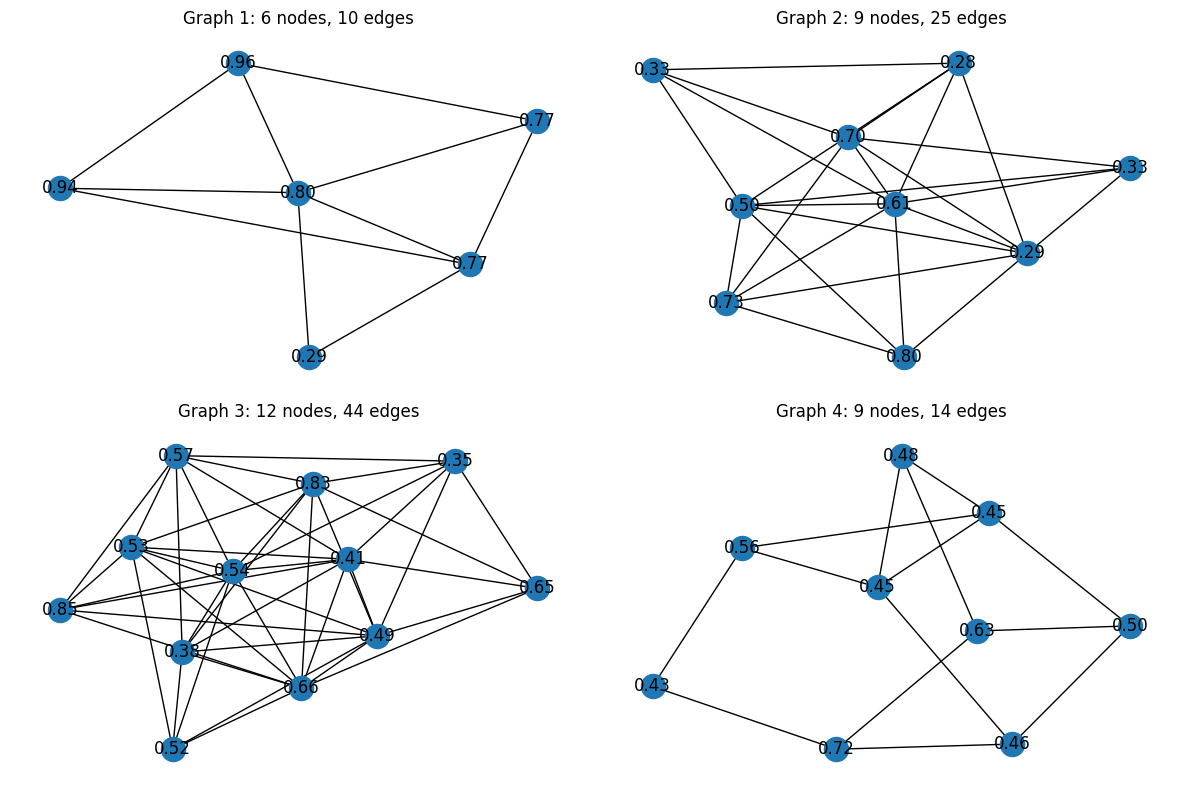

0.7974238714485382
0.7700612176014103
0.956440762925937
0.2947390450335806
0.76789072804424
0.9417981392599122


In [3]:
from rustworkx.visualization import mpl_draw as draw_graph
problem = MaxCutProblem()
graphs = problem.get_erdos_renyi_graphs_paper1()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2, figsize=(12, 8))
axes = axes.flatten()

for idx, graph in enumerate(graphs):
    # Create a mapping from node indices to their values to use as labels
    
    draw_graph(graph, ax=axes[idx], with_labels=True, labels=lambda node: f"{node:.2f}")
    axes[idx].set_title(f"Graph {idx+1}")
    # Get the number of nodes and edges for each graph
    # Get the number of nodes and edges for each graph
    for idx, graph in enumerate(graphs):
        num_nodes = len(graph)
        num_edges = len(graph.edge_list())
        axes[idx].set_title(f"Graph {idx+1}: {num_nodes} nodes, {num_edges} edges")

plt.tight_layout()
plt.show()
for n in graphs[0].node_indices():
    print(graphs[0][n])


In [ ]:
from ipywidgets import interact, interactive_output, widgets, HBox, VBox
import matplotlib.pyplot as plt
import ast, pandas as pd

# --- basic controls ----------------------------------------------------------
graph_names = ['All'] + results['graph_name'].unique().tolist()
y_options   = ['ratio', 'time_elapsed', 'quantum_func_evals', 'percent_measure_optimal']
x_options   = ['qaoa_variant', 'depth', 'hamming_dist', 'warm_start',
               'lagrangian_multiplier','backend_mode']
hue_options = x_options.copy()
chart_types = ['bar', 'line', 'box']
ws_options  = [False, True]

graph_dd   = widgets.Dropdown(options=graph_names,  description='Graph:')
x_dd       = widgets.Dropdown(options=x_options,     description='X axis:')
y_dd       = widgets.Dropdown(options=y_options,     description='Y axis:')
hues_ms    = widgets.SelectMultiple(options=hue_options, description='Hues:')
chart_dd   = widgets.Dropdown(options=chart_types,   description='Chart:')
ws_dd      = widgets.Dropdown(options=ws_options,    description='Exclude WS?')

# --- helper to build one "filter row" ----------------------------------------
all_cols   = results.columns.tolist()
ops        = ['>', '>=', '<', '<=', '==', '!=']

def make_filter_row(i: int):
    """Return widgets for a single filter row."""
    enable   = widgets.Checkbox(value=False, description=f'Filter {i}')
    col      = widgets.Dropdown(options=all_cols, description='Column')
    op       = widgets.Dropdown(options=ops,      description='Op')
    val      = widgets.Text(description='Value')
    return enable, col, op, val

flt1_enable, flt1_col, flt1_op, flt1_val = make_filter_row(1)
flt2_enable, flt2_col, flt2_op, flt2_val = make_filter_row(2)

filter_box = VBox([
    HBox([flt1_enable, flt1_col, flt1_op, flt1_val]),
    HBox([flt2_enable, flt2_col, flt2_op, flt2_val])
])

# --- function that actually draws -------------------------------------------
def _apply_single_filter(df, enable, col, op, val):
    """Apply one filter if `enable` is True."""
    if not enable or col not in df.columns:
        return df  # skip invalid filters

    try:
        # Try evaluating the value as a Python literal
        val = ast.literal_eval(val)
    except (ValueError, SyntaxError):
        try:
            # Fallback: coerce to column's dtype
            val = df[col].dtype.type(val)
        except Exception:
            pass  # Leave it as-is if all else fails

    expr = f"`{col}` {op} @val"
    return df.query(expr)


def update_visualization(graph_name, x, y, hues, chart,
                         exclude_warmstart,
                         # filter-1 widgets
                         f1_en, f1_col, f1_op, f1_val,
                         # filter-2 widgets
                         f2_en, f2_col, f2_op, f2_val):
    
    # --- start with the selected graph(s) ------------------------------------
    if graph_name == 'All':

        df = results.copy() 
    else:
        df = results[results['graph_name'] == graph_name].copy()
    
    # --- built-in warm-start exclusion ---------------------------------------
    if exclude_warmstart:
        df = df[df['hamming_dist'] == 0]
    
    # --- apply the two optional filters --------------------------------------
    df = _apply_single_filter(df, f1_en, f1_col, f1_op, f1_val)
    df = _apply_single_filter(df, f2_en, f2_col, f2_op, f2_val)
    
    # --- tidy + call your plotting helper ------------------------------------
    if hues:
        df = df.sort_values(by=[x] + list(hues))
    visualize(df, x=x, y=y, hues=list(hues), chart=chart)

# --- wire everything up ------------------------------------------------------
ui = VBox([
    HBox([graph_dd, x_dd, y_dd]),
    HBox([hues_ms, chart_dd, ws_dd]),
    filter_box
])

out = interactive_output(
    update_visualization,
    {
        'graph_name': graph_dd, 'x': x_dd, 'y': y_dd, 'hues': hues_ms,
        'chart': chart_dd, 'exclude_warmstart': ws_dd,
        
        # pipe the widgets for the two filters
        'f1_en': flt1_enable, 'f1_col': flt1_col, 'f1_op': flt1_op, 'f1_val': flt1_val,
        'f2_en': flt2_enable, 'f2_col': flt2_col, 'f2_op': flt2_op, 'f2_val': flt2_val
    }
)

display(ui, out)


Output()